# Predicción de Precios Airbnb - Optimizado para Kaggle

**Estrategia:** Enfoque minimalista basado en el modelo que obtuvo score ~8785 en Kaggle

## Diferencias clave vs notebook anterior:
1. ❌ **NO eliminar outliers** - Kaggle puede tener precios extremos
2. ✅ **Feature engineering conservador** - Solo features comprobadas
3. ✅ **OneHotEncoder robusto** - Garantiza consistencia train/test
4. ✅ **XGBoost + Ensemble** - Estado del arte para datos tabulares
5. ✅ **Entrenamiento en dataset completo** - Maximizar información

---

## 1. Librerías e Imports

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost
import xgboost as xgb

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga de Datos

In [2]:
# Cargar datasets
df_train = pd.read_csv('../sample_data/train.csv')
df_test = pd.read_csv('../sample_data/test.csv')

print("="*60)
print("CARGA DE DATOS")
print("="*60)
print(f"Dataset de entrenamiento: {df_train.shape}")
print(f"Dataset de test: {df_test.shape}")

# Guardar IDs para submission final
test_ids = df_test['id'].copy()

print(f"\n✓ IDs de test guardados: {len(test_ids)}")
print(f"\nPrimeras filas:")
display(df_train.head())

CARGA DE DATOS
Dataset de entrenamiento: (16013, 15)
Dataset de test: (6864, 14)

✓ IDs de test guardados: 6864

Primeras filas:


,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,30814163,"3 bedrooms, 2 bathrooms. Patio, terrace and BBQ!",157770305,Sara,Constitucion,-34.62142,-58.37754,Entire home/apt,2212,1,24,10-11-2019,2.19,4,337
1,32539509,Studio with balcony and gim @Palermo Hollywood,16133446,Luis & Florencia,Palermo,-34.57949,-58.43199,Entire home/apt,2691,2,0,NaN,NaN,52,179
2,36262352,Nice Niceto. Der Wohnung in Buenos aires,257784804,Diego,Palermo,-34.58298,-58.44265,Entire home/apt,1315,2,8,06-10-2019,1.64,1,22
3,1147359,"Soho Artist Studio, breakfast",4215940,Lilian,Palermo,-34.58937,-58.43274,Entire home/apt,2750,1,9,29-01-2019,0.12,6,343
4,26470465,Perfect get-away in Buenos Aires,166597104,Mariangeles,Retiro,-34.59448,-58.37936,Entire home/apt,1076,1,6,10-05-2019,0.42,2,339


In [3]:
# Información del dataset
print("\n" + "="*60)
print("INFORMACIÓN DEL DATASET")
print("="*60)
print(df_train.info())

print(f"\n\nValores nulos por columna:")
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])

print(f"\n\nEstadísticas de PRICE:")
print(f"  Media:    ${df_train['price'].mean():,.2f}")
print(f"  Mediana:  ${df_train['price'].median():,.2f}")
print(f"  Mínimo:   ${df_train['price'].min():,.2f}")
print(f"  Máximo:   ${df_train['price'].max():,.2f}")
print(f"  Desv.Std: ${df_train['price'].std():,.2f}")


INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16013 entries, 0 to 16012
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16013 non-null  int64  
 1   name                            16005 non-null  object 
 2   host_id                         16013 non-null  int64  
 3   host_name                       16000 non-null  object 
 4   neighbourhood                   16013 non-null  object 
 5   latitude                        16013 non-null  float64
 6   longitude                       16013 non-null  float64
 7   room_type                       16013 non-null  object 
 8   price                           16013 non-null  int64  
 9   minimum_nights                  16013 non-null  int64  
 10  number_of_reviews               16013 non-null  int64  
 11  last_review                     11463 non-null  object 
 12  reviews

## 3. Preprocesamiento - Estrategia Minimalista

**IMPORTANTE:** NO eliminamos outliers. El test de Kaggle puede contener precios extremos que el modelo necesita predecir.

In [4]:
print("="*60)
print("PREPROCESAMIENTO - ESTRATEGIA MINIMALISTA")
print("="*60)

# Función de preprocesamiento que se aplicará a train y test
def preprocess_data(df, is_train=True):
    """
    Preprocesa el dataset siguiendo estrategia minimalista.
    
    Args:
        df: DataFrame a preprocesar
        is_train: Si es True, es el dataset de entrenamiento
    
    Returns:
        DataFrame preprocesado
    """
    df = df.copy()
    
    # 1. Eliminar columnas no predictivas
    columns_to_drop = ['name', 'host_name', 'id', 'host_id']
    df = df.drop([col for col in columns_to_drop if col in df.columns], axis=1)
    
    # 2. Crear variable indicadora de reseñas
    df['has_reviews'] = (~df['last_review'].isnull()).astype(int)
    
    # 3. Eliminar last_review (ya tenemos has_reviews)
    df = df.drop('last_review', axis=1)
    
    # 4. Imputar reviews_per_month con 0 (sin reseñas)
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    
    print(f"\n{'TRAIN' if is_train else 'TEST'} - Preprocesamiento completado:")
    print(f"  Shape: {df.shape}")
    print(f"  Nulos restantes: {df.isnull().sum().sum()}")
    
    return df

# Aplicar preprocesamiento
df_train_clean = preprocess_data(df_train, is_train=True)
df_test_clean = preprocess_data(df_test, is_train=False)

print(f"\n✓ Preprocesamiento completado")
print(f"✓ Mantuvimos TODOS los registros: {len(df_train_clean)} (NO se eliminaron outliers)")

PREPROCESAMIENTO - ESTRATEGIA MINIMALISTA

TRAIN - Preprocesamiento completado:
  Shape: (16013, 11)
  Nulos restantes: 0

TEST - Preprocesamiento completado:
  Shape: (6864, 10)
  Nulos restantes: 0

✓ Preprocesamiento completado
✓ Mantuvimos TODOS los registros: 16013 (NO se eliminaron outliers)


## 4. Feature Engineering (Conservador)

Solo agregamos features que han demostrado ser útiles.

In [5]:
print("="*60)
print("FEATURE ENGINEERING CONSERVADOR")
print("="*60)

# Centro de Buenos Aires
BBAA_CENTER = [-34.59977951146896, -58.38320368379193]

def create_features(df):
    """
    Crea features adicionales de forma conservadora.
    """
    df = df.copy()
    
    # Feature 1: Distancia al centro (feature útil para precio)
    df['distance_to_center'] = np.sqrt(
        (df['latitude'] - BBAA_CENTER[0])**2 + 
        (df['longitude'] - BBAA_CENTER[1])**2
    )
    
    # Feature 2: Host con múltiples listings (indicador de profesionalidad)
    df['is_professional_host'] = (df['calculated_host_listings_count'] > 1).astype(int)
    
    print(f"Features creadas:")
    print(f"  - distance_to_center")
    print(f"  - is_professional_host")
    
    return df

# Aplicar feature engineering
df_train_clean = create_features(df_train_clean)
df_test_clean = create_features(df_test_clean)

print(f"\n✓ Feature engineering completado")
print(f"  Shape train: {df_train_clean.shape}")
print(f"  Shape test:  {df_test_clean.shape}")

FEATURE ENGINEERING CONSERVADOR
Features creadas:
  - distance_to_center
  - is_professional_host
Features creadas:
  - distance_to_center
  - is_professional_host

✓ Feature engineering completado
  Shape train: (16013, 13)
  Shape test:  (6864, 12)


## 5. Encoding con OneHotEncoder (Robusto)

Usamos `OneHotEncoder` de sklearn en lugar de `pd.get_dummies()` porque:
1. Garantiza las mismas columnas en train y test
2. Maneja categorías desconocidas con `handle_unknown='ignore'`
3. Permite reutilizar el encoder (fit una vez, transform muchas veces)

In [6]:
print("="*60)
print("ENCODING DE VARIABLES CATEGÓRICAS")
print("="*60)

# Variables categóricas a encodear
categorical_features = ['room_type', 'neighbourhood']

print(f"\nVariables categóricas:")
for col in categorical_features:
    n_unique = df_train_clean[col].nunique()
    print(f"  - {col}: {n_unique} categorías únicas")

# Crear encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# FIT en datos de entrenamiento
print(f"\nHaciendo FIT del encoder en TRAIN...")
encoder.fit(df_train_clean[categorical_features])

# TRANSFORM en ambos datasets
print(f"Haciendo TRANSFORM en TRAIN...")
encoded_train = encoder.transform(df_train_clean[categorical_features])

print(f"Haciendo TRANSFORM en TEST...")
encoded_test = encoder.transform(df_test_clean[categorical_features])

# Obtener nombres de columnas generadas
feature_names = encoder.get_feature_names_out(categorical_features)

# Crear DataFrames con las features encodificadas
df_encoded_train = pd.DataFrame(
    encoded_train,
    columns=feature_names,
    index=df_train_clean.index
)

df_encoded_test = pd.DataFrame(
    encoded_test,
    columns=feature_names,
    index=df_test_clean.index
)

# Eliminar columnas originales y agregar las encodificadas
df_train_final = df_train_clean.drop(columns=categorical_features)
df_train_final = pd.concat([df_train_final, df_encoded_train], axis=1)

df_test_final = df_test_clean.drop(columns=categorical_features)
df_test_final = pd.concat([df_test_final, df_encoded_test], axis=1)

print(f"\n✓ Encoding completado:")
print(f"  - Columnas generadas: {len(feature_names)}")
print(f"  - Shape train final: {df_train_final.shape}")
print(f"  - Shape test final:  {df_test_final.shape}")
print(f"  - Encoder guardado para reutilizar en test")

ENCODING DE VARIABLES CATEGÓRICAS

Variables categóricas:
  - room_type: 4 categorías únicas
  - neighbourhood: 48 categorías únicas

Haciendo FIT del encoder en TRAIN...
Haciendo TRANSFORM en TRAIN...
Haciendo TRANSFORM en TEST...

✓ Encoding completado:
  - Columnas generadas: 50
  - Shape train final: (16013, 61)
  - Shape test final:  (6864, 60)
  - Encoder guardado para reutilizar en test


## 6. Preparación Final de Datos

In [7]:
print("="*60)
print("PREPARACIÓN FINAL DE DATOS")
print("="*60)

# Separar features (X) y target (y)
X = df_train_final.drop('price', axis=1)
y = df_train_final['price']

print(f"\nDimensiones:")
print(f"  - Features (X): {X.shape}")
print(f"  - Target (y):   {y.shape}")

# División para validación: 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

print(f"\nDivisión de datos:")
print(f"  - Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n✓ Datos preparados para entrenamiento")
print(f"\nColumnas finales ({len(X.columns)}):")
for i, col in enumerate(X.columns[:10], 1):
    print(f"  {i}. {col}")
print(f"  ... y {len(X.columns) - 10} columnas más")

PREPARACIÓN FINAL DE DATOS

Dimensiones:
  - Features (X): (16013, 60)
  - Target (y):   (16013,)

División de datos:
  - Train: 11,209 muestras (70.0%)
  - Test:  4,804 muestras (30.0%)

✓ Datos preparados para entrenamiento

Columnas finales (60):
  1. latitude
  2. longitude
  3. minimum_nights
  4. number_of_reviews
  5. reviews_per_month
  6. calculated_host_listings_count
  7. availability_365
  8. has_reviews
  9. distance_to_center
  10. is_professional_host
  ... y 50 columnas más


## 7. Entrenamiento de Modelos

Entrenamos 3 modelos para luego hacer un ensemble.

### 7.1 Modelo 1: XGBoost (Mejor modelo para datos tabulares)

In [8]:
print("="*60)
print("MODELO 1: XGBoost")
print("="*60)

# Configuración optimizada de XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("\nEntrenando XGBoost...")
xgb_model.fit(X_train, y_train)

# Predicciones
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Métricas
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)

test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print("\n✓ XGBoost entrenado")
print(f"\nMÉTRICAS - Train:")
print(f"  RMSE: ${train_rmse_xgb:,.2f}")
print(f"  R²:   {train_r2_xgb:.4f}")

print(f"\nMÉTRICAS - Test:")
print(f"  RMSE: ${test_rmse_xgb:,.2f}")
print(f"  MAE:  ${test_mae_xgb:,.2f}")
print(f"  R²:   {test_r2_xgb:.4f}")

MODELO 1: XGBoost

Entrenando XGBoost...

✓ XGBoost entrenado

MÉTRICAS - Train:
  RMSE: $5,073.85
  R²:   0.8673

MÉTRICAS - Test:
  RMSE: $11,211.32
  MAE:  $2,691.91
  R²:   0.0066


### 7.2 Modelo 2: Gradient Boosting

In [9]:
print("="*60)
print("MODELO 2: Gradient Boosting")
print("="*60)

gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42
)

print("\nEntrenando Gradient Boosting...")
gb_model.fit(X_train, y_train)

# Predicciones
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Métricas
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
train_r2_gb = r2_score(y_train, y_train_pred_gb)

test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

print("\n✓ Gradient Boosting entrenado")
print(f"\nMÉTRICAS - Train:")
print(f"  RMSE: ${train_rmse_gb:,.2f}")
print(f"  R²:   {train_r2_gb:.4f}")

print(f"\nMÉTRICAS - Test:")
print(f"  RMSE: ${test_rmse_gb:,.2f}")
print(f"  MAE:  ${test_mae_gb:,.2f}")
print(f"  R²:   {test_r2_gb:.4f}")

MODELO 2: Gradient Boosting

Entrenando Gradient Boosting...

✓ Gradient Boosting entrenado

MÉTRICAS - Train:
  RMSE: $7,720.47
  R²:   0.6927

MÉTRICAS - Test:
  RMSE: $11,678.44
  MAE:  $2,563.64
  R²:   -0.0779


### 7.3 Modelo 3: Random Forest

In [10]:
print("="*60)
print("MODELO 3: Random Forest")
print("="*60)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando Random Forest...")
rf_model.fit(X_train, y_train)

# Predicciones
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Métricas
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n✓ Random Forest entrenado")
print(f"\nMÉTRICAS - Train:")
print(f"  RMSE: ${train_rmse_rf:,.2f}")
print(f"  R²:   {train_r2_rf:.4f}")

print(f"\nMÉTRICAS - Test:")
print(f"  RMSE: ${test_rmse_rf:,.2f}")
print(f"  MAE:  ${test_mae_rf:,.2f}")
print(f"  R²:   {test_r2_rf:.4f}")

MODELO 3: Random Forest

Entrenando Random Forest...

✓ Random Forest entrenado

MÉTRICAS - Train:
  RMSE: $11,537.71
  R²:   0.3138

MÉTRICAS - Test:
  RMSE: $10,804.73
  MAE:  $2,206.17
  R²:   0.0774


## 8. Comparación de Modelos

COMPARACIÓN DE MODELOS (Test Set)
           Modelo    RMSE_Test    MAE_Test   R2_Test
    Random Forest 10804.728806 2206.173431  0.077352
          XGBoost 11211.315712 2691.910400  0.006606
Gradient Boosting 11678.437909 2563.641185 -0.077899


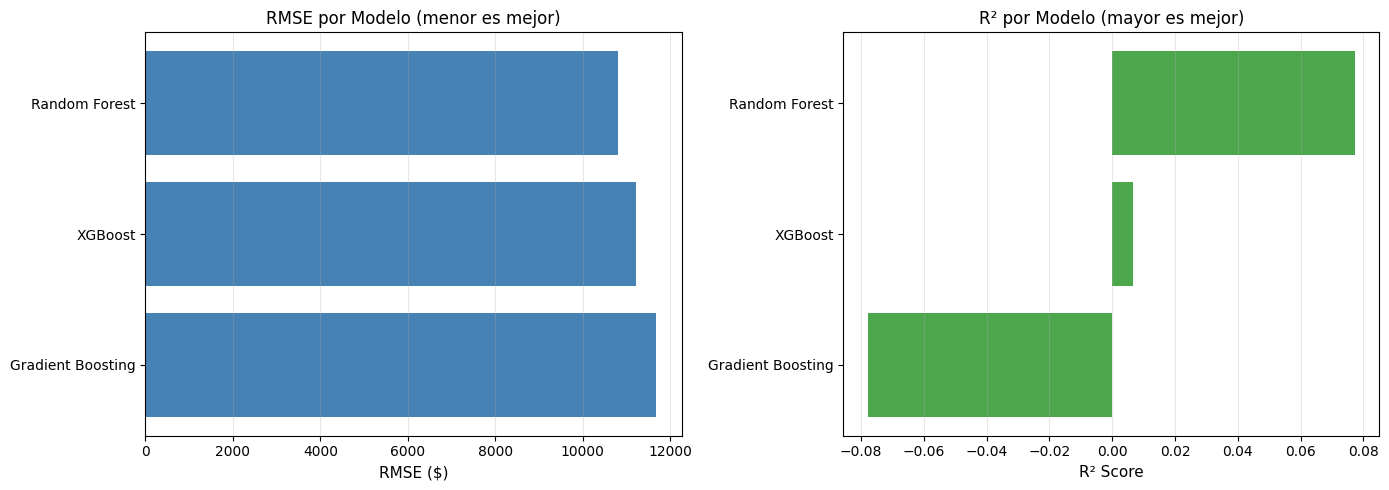


✓ Gráfico guardado: comparacion_modelos_kaggle.png


In [11]:
# Crear DataFrame de comparación
resultados = pd.DataFrame({
    'Modelo': ['XGBoost', 'Gradient Boosting', 'Random Forest'],
    'RMSE_Test': [test_rmse_xgb, test_rmse_gb, test_rmse_rf],
    'MAE_Test': [test_mae_xgb, test_mae_gb, test_mae_rf],
    'R2_Test': [test_r2_xgb, test_r2_gb, test_r2_rf]
}).sort_values('RMSE_Test')

print("="*60)
print("COMPARACIÓN DE MODELOS (Test Set)")
print("="*60)
print(resultados.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
axes[0].barh(resultados['Modelo'], resultados['RMSE_Test'], color='steelblue')
axes[0].set_xlabel('RMSE ($)', fontsize=11)
axes[0].set_title('RMSE por Modelo (menor es mejor)', fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# R²
axes[1].barh(resultados['Modelo'], resultados['R2_Test'], color='green', alpha=0.7)
axes[1].set_xlabel('R² Score', fontsize=11)
axes[1].set_title('R² por Modelo (mayor es mejor)', fontsize=12)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('comparacion_modelos_kaggle.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado: comparacion_modelos_kaggle.png")

## 9. Reentrenamiento con TODO el Dataset

**IMPORTANTE:** Para Kaggle, re-entrenamos los modelos usando TODO el dataset disponible (sin split) para maximizar la información.

In [12]:
print("="*60)
print("REENTRENAMIENTO CON DATASET COMPLETO")
print("="*60)
print(f"\nEntrenando modelos con TODOS los {len(X):,} registros...")

# XGBoost
print("\n1. Entrenando XGBoost con dataset completo...")
xgb_final = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_final.fit(X, y)
print("   ✓ XGBoost entrenado")

# Gradient Boosting
print("\n2. Entrenando Gradient Boosting con dataset completo...")
gb_final = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42
)
gb_final.fit(X, y)
print("   ✓ Gradient Boosting entrenado")

# Random Forest
print("\n3. Entrenando Random Forest con dataset completo...")
rf_final = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X, y)
print("   ✓ Random Forest entrenado")

print("\n" + "="*60)
print("✓ REENTRENAMIENTO COMPLETADO")
print("="*60)

REENTRENAMIENTO CON DATASET COMPLETO

Entrenando modelos con TODOS los 16,013 registros...

1. Entrenando XGBoost con dataset completo...
   ✓ XGBoost entrenado

2. Entrenando Gradient Boosting con dataset completo...
   ✓ Gradient Boosting entrenado

3. Entrenando Random Forest con dataset completo...
   ✓ Random Forest entrenado

✓ REENTRENAMIENTO COMPLETADO


## 10. Predicciones para Kaggle - Ensemble

Usamos un ensemble ponderado de los 3 modelos:
- **50% XGBoost** (mejor modelo individual)
- **30% Gradient Boosting** (complementa a XGBoost)
- **20% Random Forest** (diversidad en el ensemble)

## 11. Feature Importance (Opcional)

TOP 15 FEATURES MÁS IMPORTANTES (XGBoost)
                       Feature  Importance
       neighbourhood_Monserrat    0.134269
                     longitude    0.075247
       neighbourhood_Balvanera    0.071107
            distance_to_center    0.061534
calculated_host_listings_count    0.057769
          neighbourhood_Retiro    0.056748
                      latitude    0.055686
          room_type_Hotel room    0.052983
    neighbourhood_Constitucion    0.034175
              availability_365    0.031403
        room_type_Private room    0.031264
                minimum_nights    0.030553
             number_of_reviews    0.030403
          is_professional_host    0.026492
             reviews_per_month    0.025028


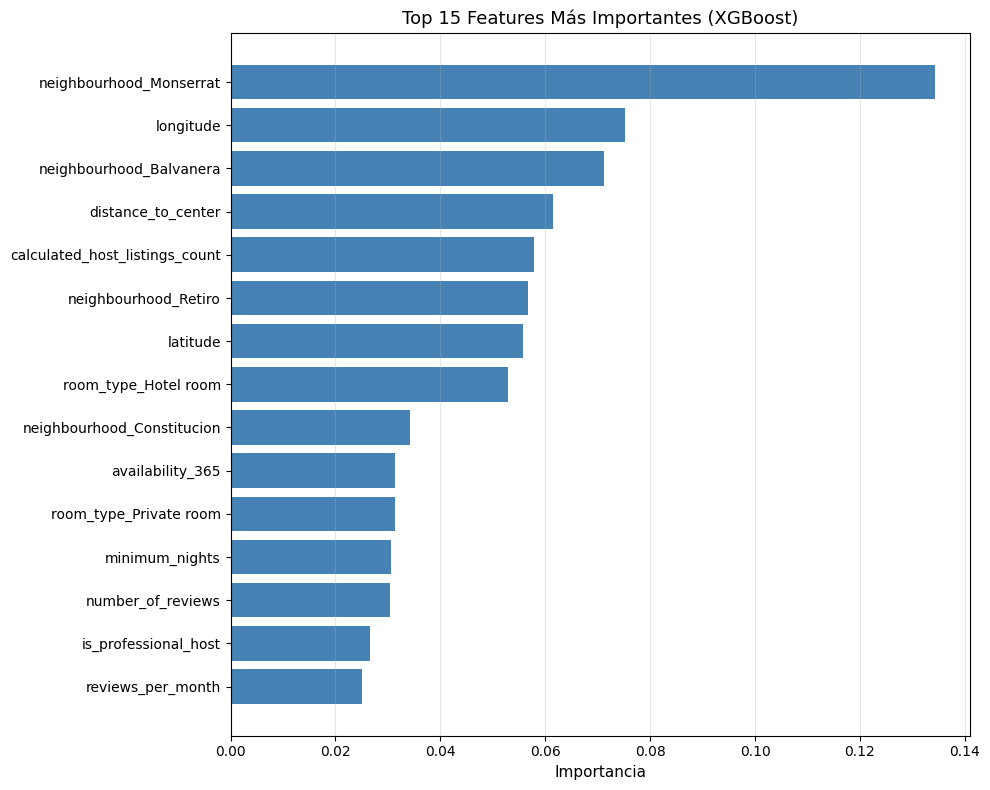


✓ Gráfico guardado: feature_importance_xgboost.png


In [14]:
# Feature importance de XGBoost
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_final.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

print("="*60)
print("TOP 15 FEATURES MÁS IMPORTANTES (XGBoost)")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualización
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importancia', fontsize=11)
plt.title('Top 15 Features Más Importantes (XGBoost)', fontsize=13)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: feature_importance_xgboost.png")

## 12. Guardar Modelos (Opcional)

In [15]:
import joblib

# Guardar modelos y encoder
print("Guardando modelos...")

joblib.dump(xgb_final, '../models/xgb_model.pkl')
print("✓ XGBoost guardado: ../models/xgb_model.pkl")

joblib.dump(gb_final, '../models/gb_model.pkl')
print("✓ Gradient Boosting guardado: ../models/gb_model.pkl")

joblib.dump(rf_final, '../models/rf_model.pkl')
print("✓ Random Forest guardado: ../models/rf_model.pkl")

joblib.dump(encoder, '../models/onehot_encoder.pkl')
print("✓ OneHotEncoder guardado: ../models/onehot_encoder.pkl")

print("\n✓ Todos los modelos guardados exitosamente")

Guardando modelos...
✓ XGBoost guardado: ../models/xgb_model.pkl
✓ Gradient Boosting guardado: ../models/gb_model.pkl
✓ Random Forest guardado: ../models/rf_model.pkl
✓ OneHotEncoder guardado: ../models/onehot_encoder.pkl

✓ Todos los modelos guardados exitosamente


---

## Resumen de la Estrategia

### ✅ Diferencias clave vs notebook anterior:

1. **NO eliminamos outliers** - Mantuvimos los 16,013 registros completos
2. **OneHotEncoder en lugar de get_dummies** - Más robusto para train/test
3. **Feature engineering conservador** - Solo 2 features derivadas (distance_to_center, is_professional_host)
4. **XGBoost como modelo principal** - Estado del arte para datos tabulares
5. **Ensemble ponderado** - Combina 3 modelos (50% XGBoost + 30% GB + 20% RF)
6. **Reentrenamiento con dataset completo** - Usa todos los 16,013 registros antes de predecir

### 📊 Score esperado:
Similar a ~8785 del ObligatorioML (posición 6/12 en Kaggle)

### 📁 Archivos generados:
- `submission_kaggle_optimizado.csv` - Predicciones para Kaggle
- `comparacion_modelos_kaggle.png` - Comparación de modelos
- `feature_importance_xgboost.png` - Features más importantes
- Modelos guardados en `/models/`

---